In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from sklearn.datasets import make_classification
from tensorflow.keras.models import load_model

In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.3)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory('./hist_images_truncated/train/', 
                                                    batch_size=16, subset="training", 
                                                    class_mode='binary', 
                                                    target_size=(200, 200))
valid_generator = train_datagen.flow_from_directory('./hist_images_truncated/train/', 
                                                    batch_size=16, subset="validation", 
                                                    class_mode='binary', 
                                                    target_size=(200, 200))
test_generator = test_datagen.flow_from_directory('./hist_images_truncated/test/', 
                                                  batch_size=16, 
                                                  class_mode='binary',
                                                  # Read note below 
                                                  shuffle=False,
                                                  target_size=(200, 200))

Found 36682 images belonging to 2 classes.
Found 15719 images belonging to 2 classes.
Found 22489 images belonging to 2 classes.


In [3]:
class_weights = {0:1, 1:1.5}

In [4]:
next(train_generator)[0].shape

(16, 200, 200, 3)

In [6]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(l=0.01), padding='same', input_shape=[200, 200, 3]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(64, 2, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 2, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.5),
    
    keras.layers.Flatten(),    
    keras.layers.Dense(16, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=[
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_custom_cnn.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()
]


history = model.fit(train_generator,
                    validation_data = valid_generator,
                    callbacks = callbacks,
                    epochs = 25,
                    class_weight = class_weights)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 200, 200, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                        

In [5]:
model = load_model('breast_cancer_custom_cnn.h5')

model.evaluate(test_generator)

1406/1406 [==============================] - 58s 37ms/step - loss: 0.6177 - binary_accuracy: 0.7850 - precision: 0.8233 - recall: 0.4474 - auc: 0.8403


[0.6176519393920898,
 0.7850059866905212,
 0.8232535123825073,
 0.44741079211235046,
 0.8403443098068237]

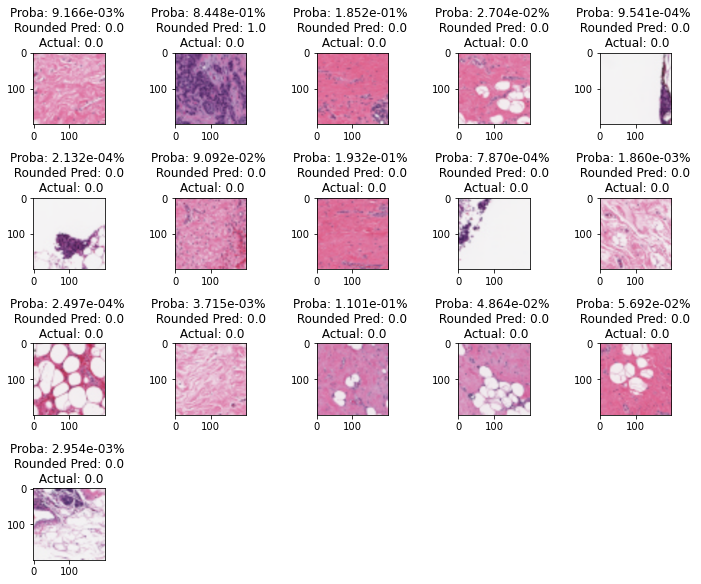

In [6]:
import cv2
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))

batch = next(test_generator)
images = batch[0]
labels = batch[1]

for index, image in enumerate(images):
    ax = fig.add_subplot(5,5,index+1)
    plt.imshow(image.astype('int'))
    
    image = np.expand_dims(image, 0)
    pred = model.predict(image)
    pred = np.squeeze(pred)
    label = labels[index]
    
    ax.set_title(f'Proba: {np.format_float_scientific(pred, precision=3)}% \n Rounded Pred: {np.round(pred)} \n Actual: {label}')
    
    
plt.tight_layout()
plt.show()

In [7]:
y_pred = model.predict(test_generator)

<AxesSubplot:ylabel='count'>

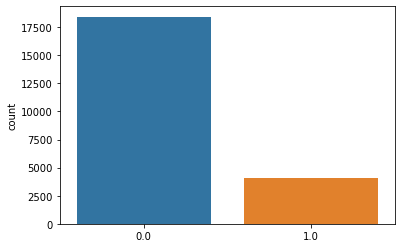

In [8]:
import seaborn as sns
sns.countplot(x=np.round(np.squeeze(y_pred)))

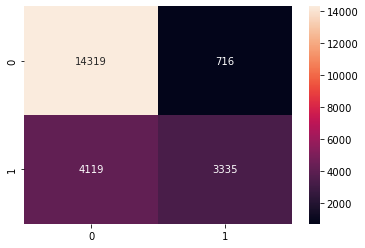

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(test_generator.classes, np.round(y_pred)), annot=True, fmt='g')
plt.show()

In [6]:
model2_1 = keras.models.Sequential([
    keras.applications.EfficientNetB0(input_shape=(200,200,3),weights='imagenet',include_top=False), 
    keras.layers.BatchNormalization(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model2_1.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_effnetb0-imagenet.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()
]

model2_1.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=[
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

history2_1 = model2_1.fit(train_generator,
                     validation_data = valid_generator,
                     callbacks = callbacks,
                     epochs = 15,
                     class_weight = class_weights)

16719872/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 1280)       5120      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                         

In [10]:
model2_1 = load_model('breast_cancer_effnetb0-imagenet.h5')

model2_1.evaluate(test_generator)

1406/1406 [==============================] - 56s 38ms/step - loss: 0.4091 - binary_accuracy: 0.8185 - precision: 0.6737 - recall: 0.8771 - auc: 0.9097


[0.40908220410346985,
 0.8184890151023865,
 0.6737427711486816,
 0.8771129846572876,
 0.9097219109535217]

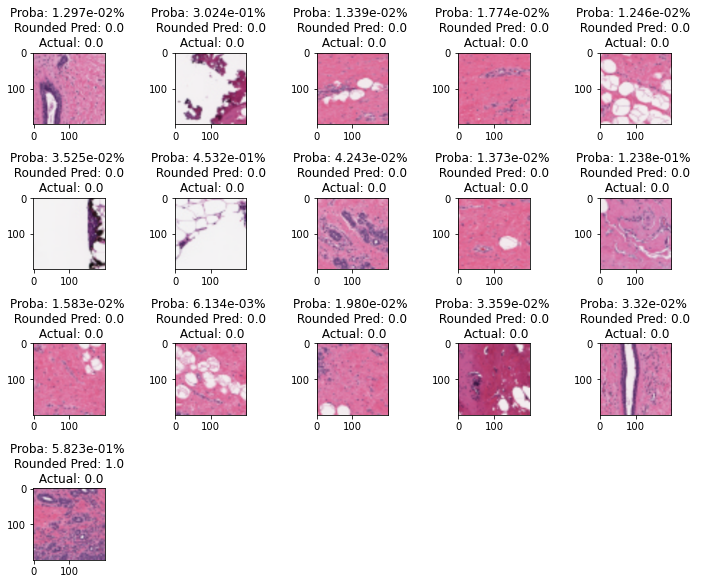

In [11]:
import cv2
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))

batch = next(test_generator)
images = batch[0]
labels = batch[1]

for index, image in enumerate(images):
    ax = fig.add_subplot(5,5,index+1)
    plt.imshow(image.astype('int'))
    
    image = np.expand_dims(image, 0)
    pred = model2_1.predict(image)
    pred = np.squeeze(pred)
    label = labels[index]
    
    ax.set_title(f'Proba: {np.format_float_scientific(pred, precision=3)}% \n Rounded Pred: {np.round(pred)} \n Actual: {label}')
    
    
plt.tight_layout()
plt.show()

In [12]:
y_pred = model2_1.predict(test_generator)

<AxesSubplot:ylabel='count'>

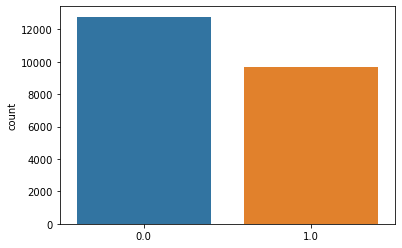

In [13]:
import seaborn as sns
sns.countplot(x=np.round(np.squeeze(y_pred)))

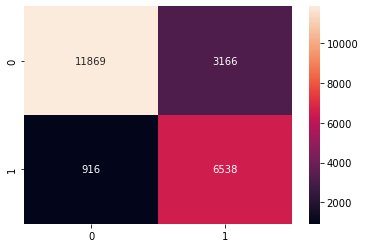

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(test_generator.classes, np.round(y_pred)), annot=True, fmt='g')
plt.show()

In [13]:
model3 = keras.models.Sequential([
    keras.applications.VGG16(input_shape=(200,200,3),weights='imagenet',include_top=False), 
    keras.layers.BatchNormalization(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model3.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_vgg16.h5',  save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()
]

model3.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=[
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

history3 = model3.fit(train_generator,
                     validation_data = valid_generator,
                     callbacks = callbacks,
                     epochs = 15,
                     class_weight = class_weights)

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 batch_normalization_1 (Batc  (None, 6, 6, 512)        2048      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                       

In [15]:
model3 = load_model('breast_cancer_vgg16.h5')

model3.evaluate(test_generator)

1406/1406 [==============================] - 53s 36ms/step - loss: 0.3867 - binary_accuracy: 0.8297 - precision_1: 0.7311 - recall_1: 0.7691 - auc_1: 0.8936


[0.38672131299972534,
 0.8296945095062256,
 0.7310634851455688,
 0.7691172361373901,
 0.8936406373977661]

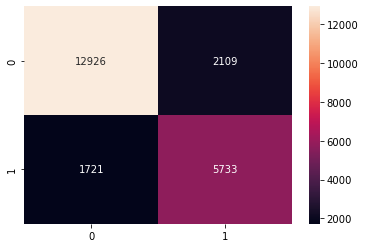

In [16]:
y_pred = model3.predict(test_generator)

import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(test_generator.classes, np.round(y_pred)), annot=True, fmt='g')
plt.show()

In [16]:
model4 = keras.models.Sequential([
    keras.applications.ResNet50(input_shape=(200,200,3),weights='imagenet',include_top=False), 
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model4.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_resnet50.h5',  save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()
]

model4.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=[
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

history4 = model4.fit(train_generator,
                     validation_data = valid_generator,
                     callbacks = callbacks,
                     epochs = 15,
                     class_weight = class_weights)

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,850,113
Trainable params: 23,796,993
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/15
2293/2293 [================

In [17]:
model4 = load_model('breast_cancer_resnet50.h5')

model4.evaluate(test_generator)

1406/1406 [==============================] - 56s 39ms/step - loss: 0.4187 - binary_accuracy: 0.7988 - precision_2: 0.8201 - recall_2: 0.5035 - auc_2: 0.8837


[0.4186561107635498,
 0.7988349795341492,
 0.8201485872268677,
 0.5034880638122559,
 0.8836614489555359]

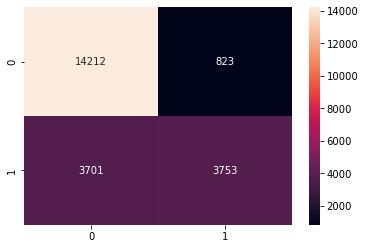

In [18]:
y_pred = model4.predict(test_generator)

import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(test_generator.classes, np.round(y_pred)), annot=True, fmt='g')
plt.show()

In [19]:
model5 = keras.models.Sequential([
    keras.applications.Xception(input_shape=(200,200,3),weights='imagenet',include_top=False), 
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model5.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_xception.h5',  save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()
]

model5.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=[
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

history5 = model5.fit(train_generator,
                     validation_data = valid_generator,
                     callbacks = callbacks,
                     epochs = 15,
                     class_weight = class_weights)


83697664/83683744 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,123,881
Trainable params: 21,069,353
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/15
2293/2293 [================

In [19]:
model5 = load_model('breast_cancer_xception.h5')

model5.evaluate(test_generator)

1406/1406 [==============================] - 55s 38ms/step - loss: 0.3079 - binary_accuracy: 0.8700 - precision_3: 0.7524 - recall_3: 0.9060 - auc_3: 0.9456


[0.30793604254722595,
 0.8700253367424011,
 0.7524234056472778,
 0.905956506729126,
 0.9455817341804504]

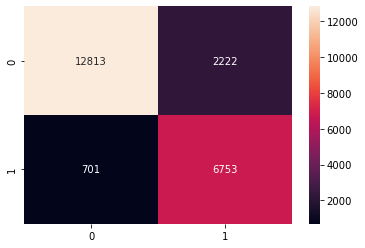

In [20]:
y_pred = model5.predict(test_generator)

import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(test_generator.classes, np.round(y_pred)), annot=True, fmt='g')
plt.show()

1406/1406 [==============================] - 53s 38ms/step - loss: 0.3079 - binary_accuracy: 0.8700 - precision_3: 0.7524 - recall_3: 0.9060 - auc_3: 0.9456
              Recall  Precision       AUC
Custom CNN  0.447411   0.823254  0.840344
EffNetB0    0.877113   0.673743  0.909722
VGG16       0.769117   0.731063  0.893641
ResNet50    0.503488   0.820149  0.883661
Xception    0.905957   0.752423  0.945582


<AxesSubplot:xlabel='variable', ylabel='value'>

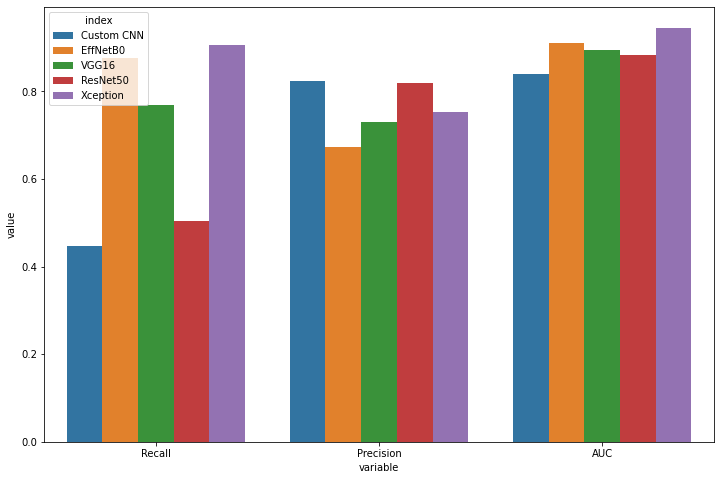

In [21]:
# Evaluate the models to get performance stats
preds_custom = model.evaluate(test_generator)
preds_effnet = model2_1.evaluate(test_generator)
preds_vgg = model3.evaluate(test_generator)
preds_resnet = model4.evaluate(test_generator)
preds_xception = model5.evaluate(test_generator)

# Extract into relevant model-related stats
cnn_recall, cnn_precision, cnn_auc, cnn_params = preds_custom[3], preds_custom[2], preds_custom[4], model.count_params()
effnet_recall, effnet_precision, effnet_auc, effnet_params = preds_effnet[3], preds_effnet[2], preds_effnet[4], model2_1.count_params()
vgg_recall, vgg_precision, vgg_auc, vgg_params = preds_vgg[3], preds_vgg[2], preds_vgg[4], model3.count_params()
resnet_recall, resnet_precision, resnet_auc, resnet_params = preds_resnet[3], preds_resnet[2], preds_resnet[4], model4.count_params()
xception_recall, xception_precision, xception_auc, xcecption_params = preds_xception[3], preds_xception[2], preds_xception[4], model5.count_params()

# Create dict to hold values
data = {
    'Custom CNN' : [cnn_recall, cnn_precision, cnn_auc],
    'EffNetB0' : [effnet_recall, effnet_precision, effnet_auc],
    'VGG16' : [vgg_recall, vgg_precision, vgg_auc],
    'ResNet50' : [resnet_recall, resnet_precision, resnet_auc],
    'Xception' : [xception_recall, xception_precision, xception_auc]
}

# Dict to DF
df = pd.DataFrame(data, index = ["Recall", "Precision", "AUC"]).T

print(df)

fig, ax = plt.subplots(figsize=(12, 8))

df_bar = df.reset_index().melt(id_vars=["index"])
sns.barplot(x="variable", y="value", hue="index", data=df_bar, ax=ax)